In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cmdstanpy import CmdStanModel
from baynes.plotter import FitPlotter
from baynes.model_utils import get_stan_file
import pandas as pd
from scipy import stats
sns.set_style('ticks')
#sns.set_palette('colorblind')
sns.set_context("notebook", font_scale=1.6)
plt.rc("axes.spines", top=False, right=False)
import matplotlib as mpl
from matplotlib import cycler
colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"][4:8]#['#1b9e77','#e7298a','#d95f02','#7570b3','#66a61e','#e6ab02','#a6761d','#666666']
mpl.rcParams['axes.prop_cycle'] = cycler('color',colors)

# Example 1: fit of a poissonian process
### Generate the data

- mean of data:  6.36
- sd of data:  2.540551121312067


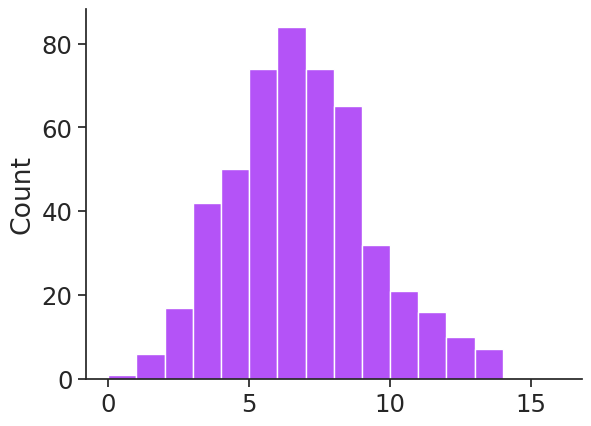

In [34]:
N=500
lambda_true = 6.3
events = np.random.poisson(lambda_true, N)

data_mean = np.mean(events)
data_sd = np.std(events)
print('- mean of data: ', data_mean)
print('- sd of data: ', data_sd)
bins = np.arange(min(events), max(events))
sns.histplot(events, bins=bins)
sns.despine()

### Compile and print the STAN model


In [35]:
stan_file = get_stan_file('poisson.stan')
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={'STAN_THREADS': True, 'jN': 4})
print(model.code())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan
data {
  int<lower=0> N;
  array[N] int y;
  real alpha;
  real beta;
  int<lower=0, upper=1> prior;
}

parameters {
  real<lower=0> lambda;
}

model {
  lambda ~ gamma(alpha, beta);
  if (prior == 0){
    y ~ poisson(lambda);
  }
}

generated quantities {
  array[N] int<lower = 0> y_rep = poisson_rng(rep_array(lambda, N));
  real<lower = 0> mean_y_rep = mean(to_vector(y_rep));
  real<lower = 0> sd_y_rep = sd(to_vector(y_rep));
}


### Assemble the data
The model fits a poissonian with a lognormal prior for the only parameter $\lambda$. The variables 'mu' and 'sigma' are the parameters of the lognormal, while 'prior' selects whether to generate simulated data only from the prior (1) or from the fit (0)

In [36]:
data = {'N': len(events), 'y': events, 'alpha': 5, 'beta': 1, 'prior': 1}

### Prior predictive check
Run the model without warmup and with fixed parameters

In [37]:
fit_prior = model.sample(data,
                         save_warmup=False)

11:47:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:25 - cmdstanpy - INFO - CmdStan done processing.


Initialize a FitPlotter object adding the fit and its title (optional), then plot a predictive check. By default, the 5-95% interval of the simulated data is drawn. If the data is unbinned, as in this case, pass the number of bins that will be used in the plot as an additional argument. 

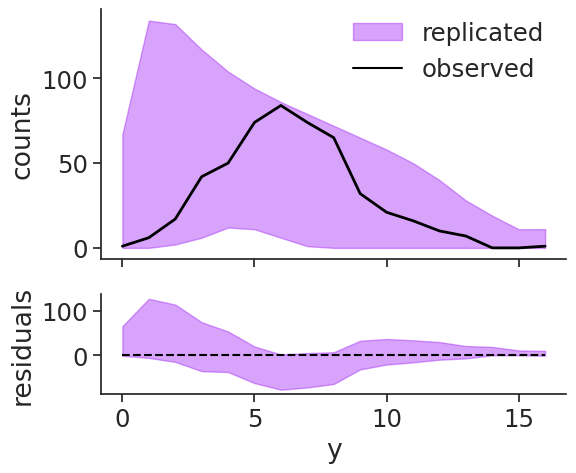

In [38]:
sns.set_style('ticks')
#sns.set_context('paper')
plt.rc("axes.spines", top=False, right=False)
#plt.rc("axes", xmargin=0, ymargin=0)
plotter = FitPlotter(fit_prior, fit_title='prior', fig_scale=6, output_dir="/home/pietro/work/TESI/thesis/figures/ch2/poisson/", output_format='.pdf')
plotter.predictive_check('y_rep', 
                         data=data, 
                         data_key='y', 
                         lines=False,
                         legend=True,
                         color=colors[0],
                         n_bins=len(bins))

### Fit the model
Allow to generate quantities depending on the fit parameter, then sample specifying the warmup iterations. Use $diagnose()$ to check the convergence of the fit.

In [39]:
data['prior'] = 0
fit = model.sample(data,
                   chains=4,
                   iter_warmup=500,
                   iter_sampling=1000,
                   save_warmup=True,
                   show_progress=True,
                   inits={'lambda':5})
print(fit.diagnose())

11:47:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:47:26 - cmdstanpy - INFO - CmdStan done processing.
11:47:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan', line 14, column 2 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan', line 14, column 2 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan', line 14, column 2 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan', line 14, column 2 to column 30)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/pietro/work/TESI/baynes/stan/models/poisson/poisson.stan', line 14, column 2 to column


Processing csv files: /tmp/tmp2o2kyv06/poissonfj0xx69z/poisson-20231015114726_1.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp2o2kyv06/poissonfj0xx69z/poisson-20231015114726_2.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp2o2kyv06/poissonfj0xx69z/poisson-20231015114726_3.csvWarning: non-fatal error reading adaptation data
, /tmp/tmp2o2kyv06/poissonfj0xx69z/poisson-20231015114726_4.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Add the new fit to the FitPlotter and inspect the convergence of the only parameter. By default, new fits are added to an internal dictionary and new graphs are generated from the last added fit. All the parameters are plotted if None is passed as the first argument of the plotting function.

/home/pietro/.virtualenvs/baynesenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


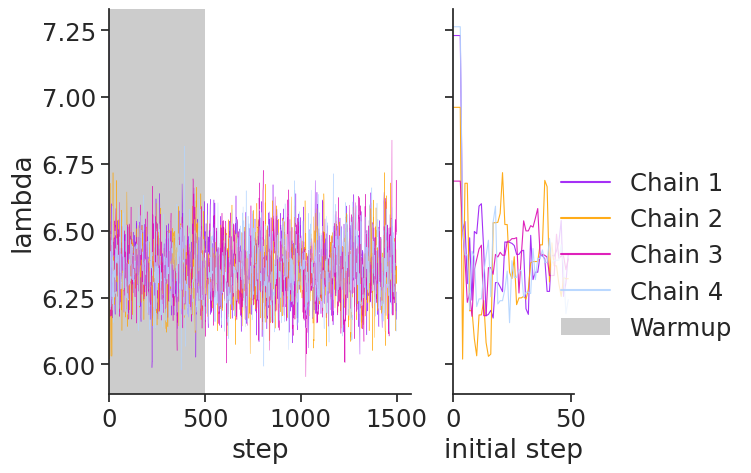

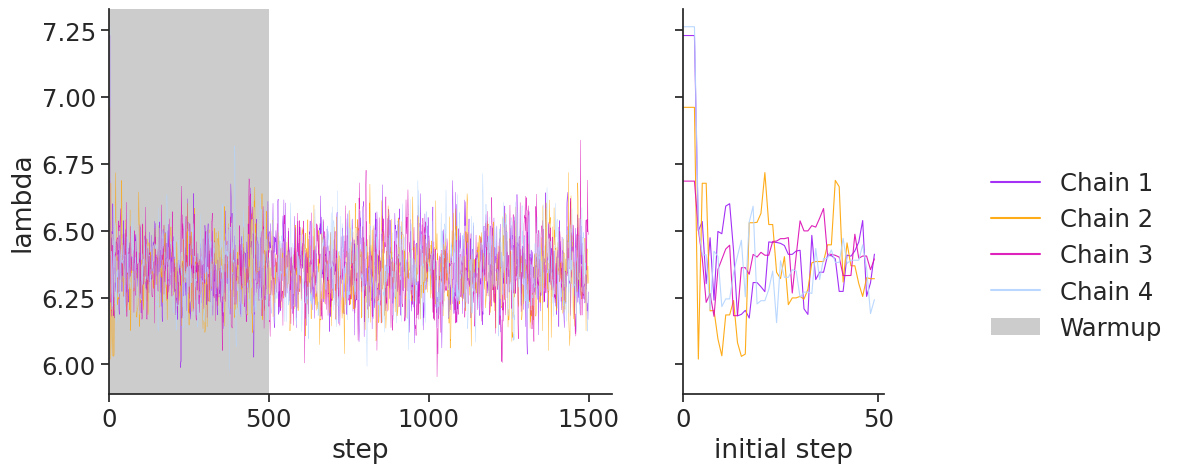

In [40]:
plotter.add_fit(fit, fit_title='posterior')
plotter.convergence_plot(wspace=0.2)
plotter.resize(10,5)

Plot the posterior predictive check

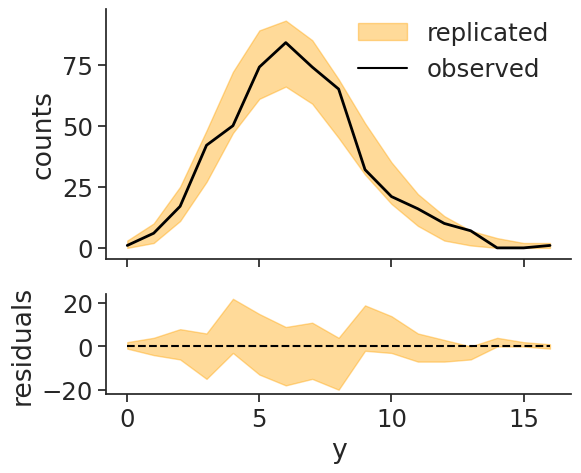

In [41]:
plotter.predictive_check('y_rep', 
                         data=data, 
                         data_key='y', 
                         lines = False,
                         n_bins=len(bins),
                         legend=True,
                         color=colors[1])

Print the results for the parameter $lambda$ and plot its posterior distribution.

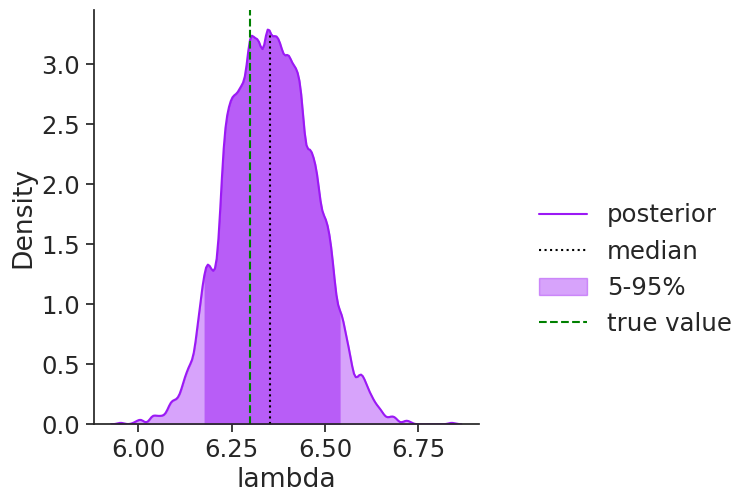

In [42]:
plotter.kde_plot()
plotter.add_lines([lambda_true], color='green', label='true value', ls='--')
plotter.resize(8,6)
plotter.get_current_figure()
#fit.summary().loc[['lambda']]

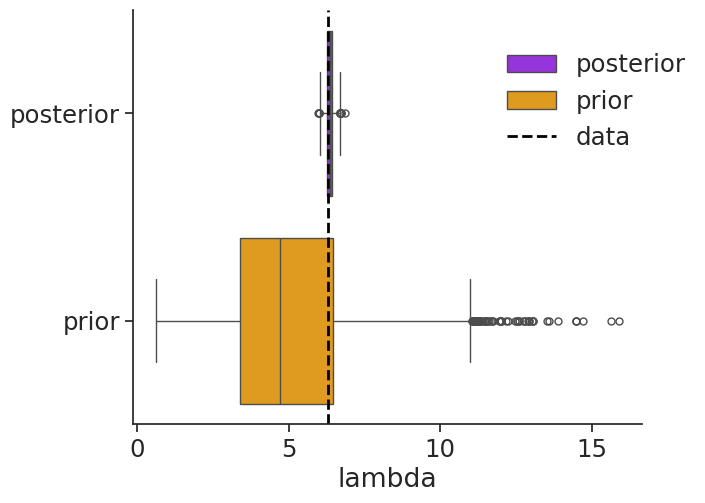

In [43]:
plotter.cat_plot(fit_titles='all', parameters='lambda')
plotter.add_lines(x_coords=[lambda_true], color='black', lw=2, ls='--', label='data')
plotter.update_legend(edgecolor='white', bbox_to_anchor=(0.75,0.85)) 
plotter.resize(15,6)

In [44]:
fit.draws_pd()['sd_y_rep']

0       2.58784
1       2.54852
2       2.66492
3       2.50826
4       2.68092
         ...   
3995    2.55668
3996    2.43263
3997    2.46862
3998    2.55019
3999    2.50679
Name: sd_y_rep, Length: 4000, dtype: float64

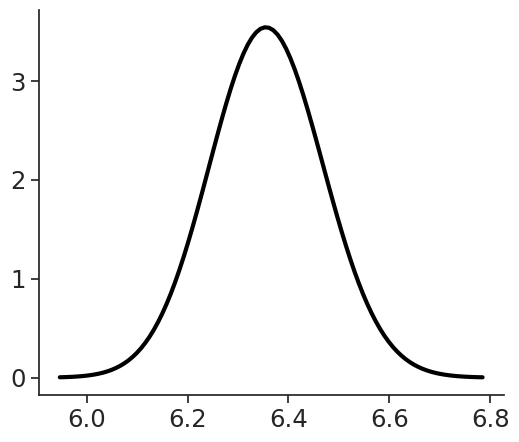

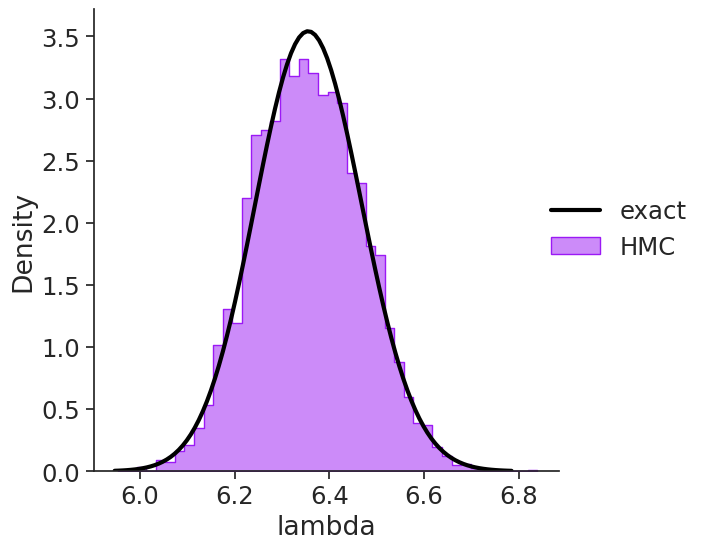

In [45]:
gamma_dist=stats.gamma(5+N*np.mean(events), scale=1/(1+N))
x = np.linspace(gamma_dist.ppf(0.0001), gamma_dist.ppf(0.9999), 100)
ax = plotter.plot(x, gamma_dist.pdf(x), color="black", lw=3, alpha=1, label='exact')
sns.histplot(fit.draws_pd(['lambda']), x='lambda', ax=ax, stat='density', label='HMC', element='step', alpha=0.5)
plotter.update_legend(bbox_to_anchor=(1.15, 0.6), facecolor='white', edgecolor='white')
plotter.resize(6,6)

In [46]:
exact = {'Mean': gamma_dist.mean(), 'StdDev': gamma_dist.std(), '5%': gamma_dist.ppf(0.05), '95%': gamma_dist.ppf(0.95)}
df = pd.concat([fit.summary().loc[['lambda']], fit_prior.summary().loc[['lambda']]])
d=df[['Mean', 'StdDev', '5%', '95%', 'N_Eff']]
d = pd.concat([pd.DataFrame.from_dict([exact]), d])
 
print(d.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & Mean & StdDev & 5% & 95% & N_Eff \\
\midrule
0 & 6.36 & 0.11 & 6.17 & 6.54 & NaN \\
lambda & 6.36 & 0.11 & 6.17 & 6.54 & 1324.87 \\
lambda & 5.08 & 2.26 & 2.01 & 9.29 & 1414.63 \\
\bottomrule
\end{tabular}



In [47]:
variables = ['mean_y_rep', 'sd_y_rep']
fits = plotter.get_fit_titles('all') 

In [48]:
res = {}
data_val=[data_mean, data_sd]
for f in fits[::-1]:
    res[f] = {}
    for i, v in enumerate(variables):
        d = plotter.draws_df(parameters=[v], fit_titles=[f])
        res[f][v] = len(d.loc[d[v]>data_val[i]])/len(d)

In [49]:
print(pd.DataFrame.from_dict(res).transpose().to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
 & mean_y_rep & sd_y_rep \\
\midrule
posterior & 0.48 & 0.41 \\
prior & 0.26 & 0.25 \\
\bottomrule
\end{tabular}



In [50]:
plotter.validate_parameters(['mean_y_rep', 'sd_y_rep'])

['mean_y_rep', 'sd_y_rep']

In [51]:
plotter.stan_variables

['lambda']

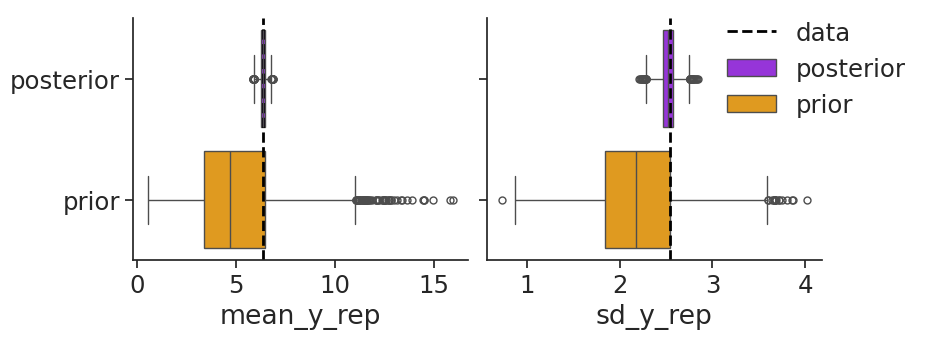

In [52]:
plotter.col_wrap=2
variables = ['mean_y_rep', 'sd_y_rep']
plotter.fig_scale = 8
plotter.cat_plot(variables, fit_titles='all')
plotter.add_lines(x_coords=[data_mean, data_sd], color='black', lw=2, ls='--', label='data')
plotter.update_legend(edgecolor='white') 
plotter.resize(9, 3)

In [53]:
plotter.save_figures("all")

Most of the plots support multiple parameters and fit combinations. For example, we can compare the prior and posterior distributions for the simulated data's mean and standard deviation. This can also be done with wrappers of Seaborn's functions $displot$ and $catplot$, allowing for many possibilities

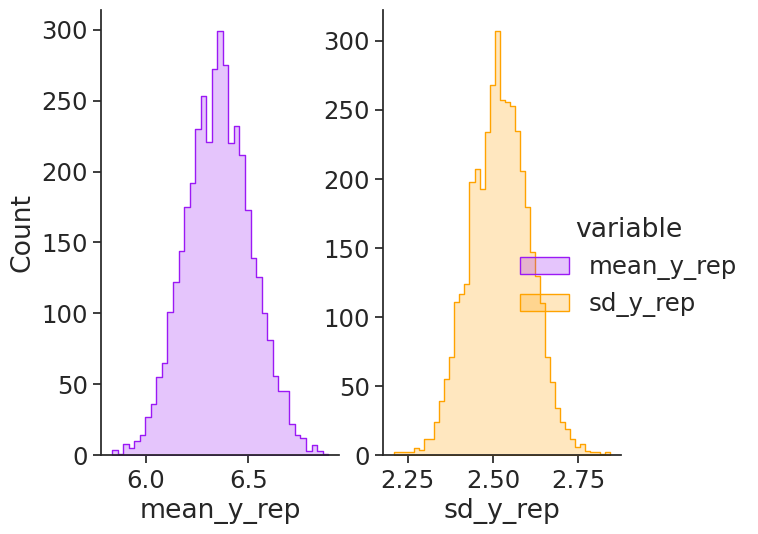

In [54]:
variables = ['mean_y_rep', 'sd_y_rep']
plotter.fig_scale = 6
plotter.dis_plot(variables, kind='hist', hue='variable', common_bins=False, element="step")

It is also possible to add vertical and horizontal lines to the last created figure. In this case we can see that not only the fit has converged to the true value, but also that the simulated data mean and standard deviation converge to that of the real data. This means that the model can qualitatively describe various properties of the data and is a good indicator of its usefulness.